## NWB-Datajoint tutorial 0

**Note: make a copy of this notebook and run the copy to avoid git conflicts in the future**

This is the zeroth in a multi-part tutorial on the NWB-Datajoint pipeline used in Loren Frank's lab, UCSF. It gives a general introduction to Datajoint and shows how to insert an NWB file into the Datajoint database, inspect and query the data, and delete it.

Let's start by importing the `nwb_datajoint` package, along with a few others. 

In [1]:
from pathlib import Path
import os
import numpy as np

import nwb_datajoint as nd

import warnings
warnings.simplefilter('ignore')

# Comment these if you have already set these environment variables
# data_dir = Path('/stelmo/nwb') # CHANGE ME TO THE BASE DIRECTORY FOR DATA STORAGE ON YOUR SYSTEM
# os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = 'TRUE'
# os.environ['KACHERY_P2P_API_PORT'] = '14747'
# os.environ['NWB_DATAJOINT_BASE_DIR'] = str(data_dir)
# os.environ['KACHERY_STORAGE_DIR'] = str(data_dir / 'kachery-storage')
# os.environ['SPIKE_SORTING_STORAGE_DIR'] = str(data_dir / 'spikesorting')

Connecting jhbak@lmf-db.cin.ucsf.edu:3306


In [2]:
# We also import a bunch of tables so that we can call them easily
from nwb_datajoint.common import RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,\
                                 DataAcquisitionDevice, CameraDevice, Probe,\
                                 DIOEvents,\
                                 ElectrodeGroup, Electrode, Raw, SampleCount,\
                                 LFPSelection, LFP, LFPBandSelection, LFPBand,\
                                 SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting,\
                                 FirFilter,\
                                 IntervalList, SortInterval,\
                                 Lab, LabMember, Institution,\
                                 BrainRegion,\
                                 SensorData,\
                                 Session, ExperimenterList,\
                                 Subject,\
                                 Task, TaskEpoch,\
                                 Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery

### Visualizing the database

Datajoint enables users to use Python to build and interact with a *relational database*, which is a fancy way of saying "a set of tables that are related to one another in some way." The following diagram (called *entity relationship diagram*) shows all the tables in our database and their relationships.

Polygons are tables:
* Blue oval: tables whose entries are imported from external files (e.g. NWB file).
* Green rectangle: tables whose entries are entered manually.
* Red circle: tables whose entries are computed from entries of other tables.
* No shape (only text): tables whose entries are part of the table upstream

Lines are *dependencies* between tables:
* Bold lines: downstream table inherits the *primary key* ^ of upstream table as its sole primary key
* Solid lines: downstream table inherits the primary key of upstream table as part of its primary key
* Dashed lines: downstream table inherits the primary key of upstream table as non-primary key

^ Primary key: a set of attributes (i.e. column names) used to uniquely define an entry (i.e. a row)

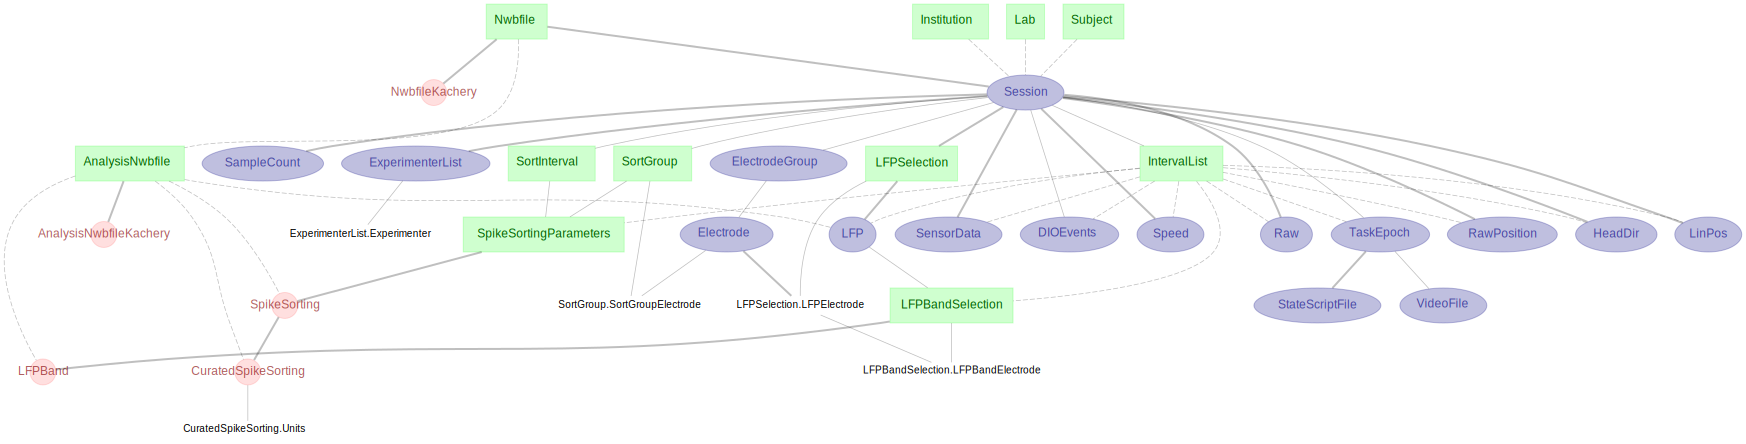

In [3]:
# Draw tables that are three levels below and one level above Session 
nd.dj.ERD(Session)-1+3

### Example data

Now that we have a general idea of how our database is organized, we will try inserting new data to it. We assume that the data is a neural recording (along with other auxiliary data) that has already been converted to the NWB format. For the purposes of this tutorial, we will use `beans20190718.nwb`. If you're accessing the Frank lab database on the UCSF network, this file can be found in `/stelmo/nwb/raw` directory (assuming you have mounted `stelmo` at `/`). If you do not have access to Frank lab database, then download `beans20190718.nwb` from [here](https://www.dropbox.com/s/srra33e0igaj5rm/beans20190718.nwb?dl=0) - it is rather big (~ 70 GB) so be aware of that. 

Once you have the NWB file, you should copy it and rename the copy to something unique (e.g. `beans20190718_yourname.nwb`). This is because many people will be using this example file to practice inserting data, and a file can only be inserted once (the file name acts as a *primary key* in the `Session` table). 

In [4]:
# Define the name of the file that you copied and renamed; make sure it's something unique. 
# nwb_file_name = 'beans20190718.nwb'
nwb_file_name = 'beans20190718_jhbak.nwb'
filename, file_extension = os.path.splitext(nwb_file_name)
# This is a copy of the original nwb file, except it doesn't contain the raw data (for storage reasons)
nwb_file_name2 = filename + '_' + file_extension

In [5]:
nwb_file_name2

'beans20190718_jhbak_.nwb'

### Inserting data

As you may know, the NWB file contains a lot of information, such as information about the experimenter (e.g. who did the experiment, where was it done, etc); the animal's behavior (e.g. video recording of the animal's position in an environment during the experiment); the neural activity (extracellular recording of multiple brain areas) etc. We wish to enter this information into the tables of our Datajoint database so that we can easily access them later. If we have an NWB file that has been properly generated, this is straightforward: just run the `nd.insert_session` function, which will populate many of the tables automatically. Let's do this for our example NWB file.

Note: this may take a while because it makes a copy of the NWB file.

In [6]:
nd.insert_sessions(nwb_file_name)

Creating a copy of NWB file beans20190718_jhbak.nwb with link to raw ephys data: beans20190718_jhbak_.nwb
Populate Session...
Institution...
Lab...
LabMember...
Subject...
DataAcquisitionDevice...
CameraDevice...
Inserted ['beans sleep camera', 'beans run camera']
Probe...
Skipping Apparatus for now...
IntervalList...
Populate ExperimenterList...
Populate ElectrodeGroup...
Populate Electrode...
Populate Raw...
Estimating sampling rate...
Estimated sampling rate: 20000.0
Importing raw data: Estimated sampling rate:	20000.0 Hz
                    Number of valid intervals:	5
Populate SampleCount...
Populate DIOEvants...
Populate SensorData
Populate TaskEpochs
Populate StateScriptFile
Populate VideoFile
RawPosition...
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz
Processing raw position data. Estimated sampling rate: 30.0 Hz


### Inspecting and querying data

To look at the tables, just call it (don't forget the `()` at the end, as tables are like Python classes). Let's try calling the `Lab` table.

In [9]:
Lab()

lab_name
Loren Frank


There is only one attribute (`lab_name`) and one entry (`Loren Frank`) in this table. Note that even though `Lab` is one of the tables that has to be manually entered (i.e. the green rectangles in our ERD), `nd.insert_sessions` populates it from the NWB file.

Let's look at a more interesting table: `Session`.

In [10]:
Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
beans20190718_jhbak_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
despereaux20191125_.nwb,Despereaux,"University of California, San Francisco",Loren Frank,4,Sungod,2019-11-25 10:17:29,1970-01-01 00:00:00,Sungod control
peanut20201117_.nwb,peanut,"University of California, San Francisco",Loren Frank,peanut_20201117,spatial alternation memory task,2020-11-17 08:50:38,1970-01-01 00:00:00,spatial alternation memory task


This session has multiple attributes. The attributes that make up the primary key are shown in bold. In this case, there is only one attribute in the primary key: `nwb_file name`. Given that many downstream tables are connected to `Session` via bold lines, you can use this attribute to uniquely define data entries in many tables in our database.

To look at specific entries from a table, include the appropriate condition with the `&` operator. The condition must be in the form of a key-value pair, or a dictionary. As an example, let's view only the entry whose `nwb_file_name` is our example NWB file in `Session`:

In [11]:
Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_jhbak_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning


Now let's go to a downstream table: `Raw`. This table is connected to `Session` table with a bold line, so it has the same primary key.

In [12]:
Raw & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
beans20190718_jhbak_.nwb,raw data valid times,d97e590f-4c09-470d-9a19-38d667b3c3da,20000.0,sample comment,Electrical series registered on electrode


`IntervalList` table is connected to `Session` table with a solid line, as it inherits `nwb_file_name` as one of the two attributes that make up the primary key. This means that you need to know both `nwb_file_name` and `interval_list_name` to uniquely identify an entry.

In [13]:
IntervalList & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
beans20190718_jhbak_.nwb,01_s1,=BLOB=
beans20190718_jhbak_.nwb,02_r1,=BLOB=
beans20190718_jhbak_.nwb,03_s2,=BLOB=
beans20190718_jhbak_.nwb,04_r2,=BLOB=
beans20190718_jhbak_.nwb,pos 0 valid times,=BLOB=
beans20190718_jhbak_.nwb,pos 1 valid times,=BLOB=
beans20190718_jhbak_.nwb,pos 2 valid times,=BLOB=
beans20190718_jhbak_.nwb,pos 3 valid times,=BLOB=
beans20190718_jhbak_.nwb,raw data valid times,=BLOB=


As you can see, some of the data is shown in the table (e.g. `interval_list_name`) while others are obscured (e.g. `valid_times` are shown as `=BLOB=`). To inspect the data, use the `fetch` (for getting multiple entries) or `fetch1` (for getting just one entry) methods. The following query returns `valid_times` of an interval list called `04_r2`.

In [15]:
(
    IntervalList & {'nwb_file_name':nwb_file_name2, 'interval_list_name':'04_r2'}
).fetch1('valid_times')

array([[1.56349543e+09, 1.56349711e+09]])

Query supports many operations and conditions - just make sure the conditions are in the form of a dictionary. For example, `-` is like the set-theoretic complement. The following query returns all `interval_list_name` that is not `01_s1` or `04_r2`.

In [16]:
(
    (IntervalList & {'nwb_file_name':nwb_file_name2}) 
     - ({'interval_list_name':'01_s1'} and \
        {'interval_list_name':'04_r2'})
).fetch('interval_list_name')

array(['01_s1', '02_r1', '03_s2', 'pos 0 valid times',
       'pos 1 valid times', 'pos 2 valid times', 'pos 3 valid times',
       'raw data valid times'], dtype=object)

Feel free to inspect other tables and learn what kind of data they contain.

### Deleting data 

Another neat feature of Datajoint is that it automatically maintains the integrity of your data. For example, if we were to delete our entry in the `Session` table, the associated entries in all of the downstream tables (e.g. `Raw`, `IntervalList`, `ElectrodeGroup` to name a few) will also be deleted. That way, there is no 'orphan' data whose origin cannot be tracked. We will do this now using the `delete` method.

In [17]:
# our data is currently in Session table
Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_jhbak_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning


In [18]:
# Type `yes` when prompted to delete
(Session & {'nwb_file_name':nwb_file_name2}).delete()

About to delete:
`common_ephys`.`_electrode`: 192 items
`common_ephys`.`_electrode_group`: 2 items
`common_ephys`.`_sample_count`: 1 items
`common_behav`.`_raw_position`: 1 items
`common_dio`.`_d_i_o_events`: 19 items
`common_ephys`.`_raw`: 1 items
`common_sensors`.`_sensor_data`: 1 items
`common_behav`.`_video_file`: 4 items
`common_task`.`_task_epoch`: 4 items
`common_interval`.`interval_list`: 9 items
`common_session`.`_experimenter_list__experimenter`: 1 items
`common_session`.`_experimenter_list`: 1 items
`common_session`.`_session`: 1 items
Proceed? [yes, No]: yes
Committed.


In [19]:
# Check that delete worked
Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


`Delete` operation is useful when you need to re-do something: rather than editing an entry (which runs the risk of violating data integrity), it is recommended that you just delete it and re-enter it. This is easy to do, as most data entry is automated in our pipeline.

In [20]:
# Entries are also gone from downstream tables, e.g. IntervalList
IntervalList & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval


We're not quite done yet. Not only should we delete our entry from `Session`, we should also delete the associated entry in `Nwbfile`. Recall from the entity relationship diagram that `Nwbfile` is upstream of `Session`. That means getting rid of our entry from `Session` doesn't affect the corresponding entry in `Nwbfile` - this has to be manually removed. To do so, we again use the `delete` method, but in the case of `Nwbfile` there is an extra step: we need to remove the NWB file itself as well as the entry from `Nwbfile` table. To remove the files, we run the `cleanup` method with the `delete_files` argument as `True`. 

Note that the same idea applies to deleting files from `AnalysisNwbfile` table. 

In [23]:
Nwbfile()

nwb_file_name name of the NWB file,nwb_file_abs_path
beans20190718_jhbak_.nwb,=BLOB=
despereaux20191125_.nwb,=BLOB=
beans20190718_.nwb,=BLOB=
peanut20201117_.nwb,=BLOB=


In [21]:
# Check out the Nwb file
Nwbfile & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,nwb_file_abs_path
beans20190718_jhbak_.nwb,=BLOB=


In [24]:
# Let's delete the entry
(Nwbfile & {'nwb_file_name':nwb_file_name2}).delete()

About to delete:
`common_nwbfile`.`nwbfile`: 1 items
Proceed? [yes, No]: yes
Committed.


In [25]:
# Note that the file (ends with _.nwb) has not been deleted, even though the entry is
!ls $NWB_DATAJOINT_BASE_DIR/raw

Jaq20190826.nwb		 beans20190718_jhbak_.nwb  peanut20201117.nwb
Jaq20190826_.nwb	 despereaux20191125.nwb    peanut20201117_.nwb
beans20190718.nwb	 despereaux20191125_.nwb   senor20201030.nwb
beans20190718_.nwb	 kachery-storage	   senor20201030_.nwb
beans20190718_jhbak.nwb  peanut20201111.nwb


In [26]:
Nwbfile()

nwb_file_name name of the NWB file,nwb_file_abs_path
despereaux20191125_.nwb,=BLOB=
beans20190718_.nwb,=BLOB=
peanut20201117_.nwb,=BLOB=


In [27]:
# We clean it up
Nwbfile().cleanup(delete_files=True)

100%|██████████| 1/1 [00:00<00:00, 38.29it/s]


In [28]:
# Now the file is gone as well
!ls $NWB_DATAJOINT_BASE_DIR/raw

Jaq20190826.nwb		 despereaux20191125.nwb   peanut20201117_.nwb
Jaq20190826_.nwb	 despereaux20191125_.nwb  senor20201030.nwb
beans20190718.nwb	 kachery-storage	  senor20201030_.nwb
beans20190718_.nwb	 peanut20201111.nwb
beans20190718_jhbak.nwb  peanut20201117.nwb
